# Integrated gradients for Mnist

In this notebook we show the usage of the IntegratedGradients class on sample images from the mnist dataset. 

The IntegratedGradients class implements the integrated gradients features attributions method. A description of the method can be found here (link to method notebook). Integrated gradients was originally proposed in here (link to paper).

In [1]:
import numpy as np
import os
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.layers import Activation, Conv2D, Conv2DTranspose, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, InputLayer, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from alibi.explainers import IntegratedGradients
import matplotlib.pyplot as plt
%matplotlib inline
%set_env CUDA_VISIBLE_DEVICES=1
tf.test.is_gpu_available()
tf.__version__

env: CUDA_VISIBLE_DEVICES=1


'1.15.0'

# Load data

In [2]:
train, test = tf.keras.datasets.mnist.load_data()
X_train, y_train = train
X_test, y_test = test

X_train = X_train.reshape(-1, 28, 28, 1).astype('float64') / 255
X_test = X_test.reshape(-1, 28, 28, 1).astype('float64') / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
test_labels = np.argmax(y_test, axis=1)
train_labels = np.argmax(y_train, axis=1)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


# Train model

Training of a convolutional neural network on the mnist dataset

In [3]:
load_mnist_model = False

In [4]:
filepath = './model_mnist/'  # change to directory where model is downloaded
if load_mnist_model:
    model = tf.keras.models.load_model(os.path.join(filepath, 'model.h5'))
else:
    # define model
    inputs = Input(shape=(X_train.shape[1:]), dtype=tf.float64)
    x = Conv2D(64, 2, padding='same', activation='relu')(inputs)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Conv2D(32, 2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(.3)(x)
    
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(.5)(x)
    logits = Dense(10, name='logits')(x)
    outputs = Activation('softmax', name='softmax')(logits)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    # train model
    model.fit(X_train,
              y_train,
              epochs=20,
              batch_size=256,
              verbose=2,
              validation_data=(X_test, y_test)
              )
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    model.save(os.path.join(filepath, 'model.h5'))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Integrated gradients

In [5]:
# Initialize IntegratedGradients instance
n_steps = 50
method = "gausslegendre"
return_convergence_delta = True
return_predictions = False
ig  = IntegratedGradients(model,
                          n_steps=n_steps, 
                          method=method,
                          return_convergence_delta=return_convergence_delta, 
                          return_predictions=return_predictions)

In [6]:
# Calculate attributions for the first 10 images in the test set
nb_samples = 10
X_test_red = X_test[:nb_samples]
test_labels_red = test_labels[:nb_samples]
explanation = ig.explain(X_test_red, 
                         baselines=None, 
                         target=test_labels_red)

In [12]:
# Get attributions values from the explanation object
attributions = explanation.data['attributions']

# Visualize attributions

True label 7


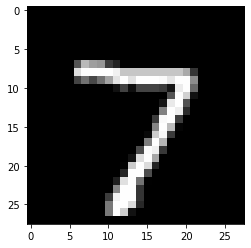

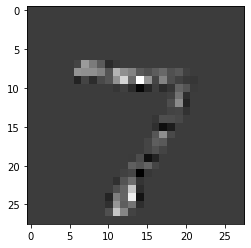

In [10]:
# Visualize first image in the test set and the values of 
# the integrated gradients attributions. 
i = 0
print('True label',test_labels[i])
plt.imshow(np.squeeze(X_test[i]), cmap='gray')
plt.show()
plt.imshow(np.squeeze(attributions[i]), cmap='gray')